# **Hands-On \#3**: Image-Text Segmentation Search (SAM & CLIP).
by Romrawin Chumpu (Jinpu)

AI Lecture - Modern Image Search

Date: January 30, 2024

Benefits:

- Search for ingredient in images
- Segmentation on the fly

Notes:
- High computational resource

Source code:

- https://github.com/Curt-Park/segment-anything-with-clip



In [ ]:
# install dataset and clip
!pip -q install datasets open_clip_torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 89.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.7 MB/s eta 0:00:00


In [ ]:
# install segment anything
!pip -q install git+https://github.com/facebookresearch/segment-anything.git
!pip -q install opencv-python pycocotools matplotlib onnxruntime onnx
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 12.6 MB/s eta 0:00:00
--2024-01-29 12:45:51--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 52.84.251.15, 52.84.251.106, 52.84.251.114, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|52.84.251.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   194MB/s    in 13s     

2024-01-29 12:46:03 (195 MB/s) - ‘sam_vit_h_4b8939.pth’ saved [2564550879/2564550879]



In [ ]:
import cv2
import torch
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# Download dataset

**Food101** dataset is used (https://huggingface.co/datasets/food101) in this hands-on

In [ ]:
from datasets import load_dataset

dataset = load_dataset("food101")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

In [ ]:
### Dataset Information ###
print("### Dataset Information ###\n")
print("Number of training images: ", len(dataset["train"]))
print("Number of labels: ", len(dataset["train"].features["label"].names))

### Dataset Information ###

Number of training images:  75750
Number of labels:  101


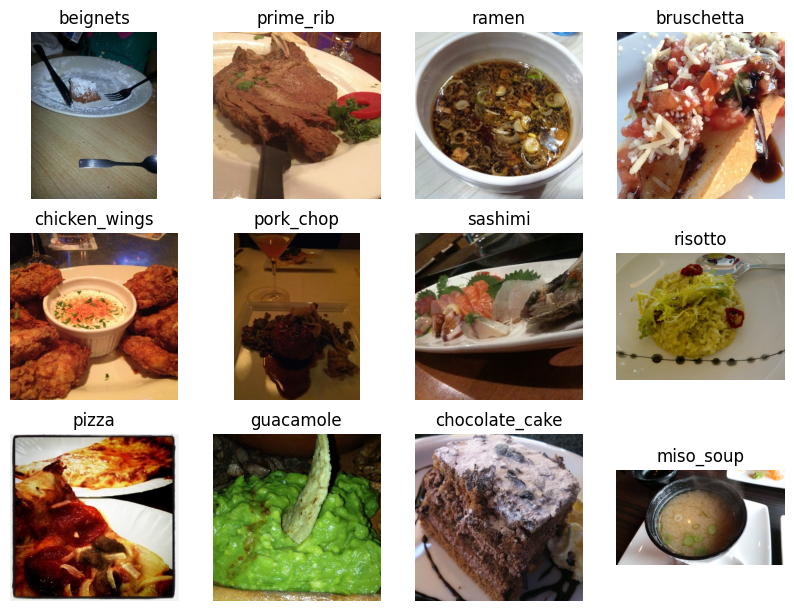

In [ ]:
id2label = {}
for i, label in enumerate(dataset["train"].features["label"].names):
  id2label[i] = label

rows = 4; cols = 4
fig = plt.figure(figsize=(10, 10))
c = 0
for i in range(0, 12000, 1000):
  ax = fig.add_subplot(rows, cols, c+1)
  image = dataset["train"][i]["image"]
  plt.imshow(image)
  plt.axis('off')
  plt.title(id2label[dataset["train"][i]["label"]])
  c+=1
plt.show()

# Load CLIP Pretrained model

In [ ]:
import open_clip

In [ ]:
# load clip
def load_clip(model_name: str = "ViT-B-32-quickgelu",
              pretrained_name: str = "openai"):
  device = "cuda" if torch.cuda.is_available() else "cpu"
  model, _, preprocess = open_clip.create_model_and_transforms(model_name,
                                                               device = device,
                                                               pretrained = pretrained_name)
  # model.load_state_dict(torch.load(pretrained_name,
  #                                  map_location = "cpu")["state_dict"])
  return model.to(device), preprocess

(-0.5, 511.5, 381.5, -0.5)

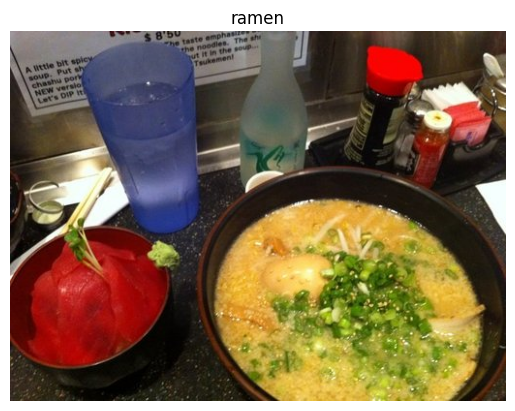

In [ ]:
test_idx = 600
image = np.array(dataset["validation"][test_idx]["image"])
label = dataset["validation"][test_idx]["label"]

plt.imshow(image)
plt.title(id2label[label])
plt.axis("off")

In [ ]:
# load segment anything model
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
sam = sam_model_registry["default"](checkpoint="/content/sam_vit_h_4b8939.pth")
# predictor = SamPredictor(sam)

In [ ]:
# Auto generate masks
mask_generator = SamAutomaticMaskGenerator(sam)
masks = mask_generator.generate(image)

# Visualize SAM masks

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

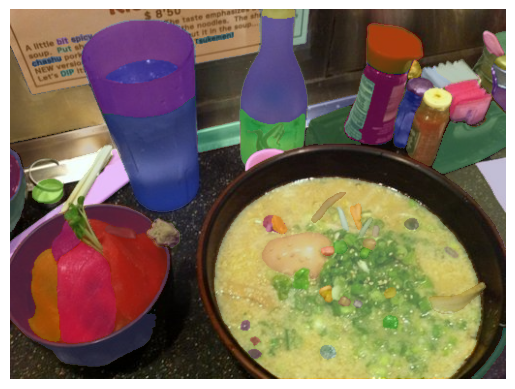

In [ ]:
# plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

# Search for specific ingredient in the image

In [ ]:
import os
import urllib
from functools import lru_cache
from random import randint
from typing import Any, Callable, Dict, List, Tuple

import open_clip
import cv2
import numpy as np
import PIL
import torch
import matplotlib.pyplot as plt
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry

In [ ]:
CHECKPOINT_PATH = "sam_vit_h_4b8939.pth"
CHECKPOINT_URL = "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth"
MODEL_TYPE = "default"
MAX_WIDTH = MAX_HEIGHT = 400
THRESHOLD = 0.05
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
@lru_cache
def load_mask_generator() -> SamAutomaticMaskGenerator:
  if not os.path.exists(os.path.join(".", CHECKPOINT_PATH)):
    urllib.request.urlretrieve(CHECKPOINT_URL, CHECKPOINT_PATH)

  sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH).to(device)
  mask_generator = SamAutomaticMaskGenerator(sam)
  return mask_generator
# mask_generator = load_mask_generator()

def adjust_image_size(image: np.ndarray) -> np.ndarray:
  height, width = image.shape[:2]
  if height > width:
    if height > MAX_HEIGHT:
      height, width = MAX_HEIGHT, int(MAX_HEIGHT / height * width)
  else:
    if width > MAX_WIDTH:
      height, width = int(MAX_WIDTH / width * height), MAX_WIDTH
  image = cv2.resize(image, (width, height))
  return image

@torch.no_grad()
def get_similarity_score(crop_images: List[PIL.Image.Image], prompt: str) -> torch.Tensor:
  from open_clip import tokenizer

  model, preprocess = load_clip()
  image_input = [preprocess(crop) for crop in crop_images]
  image_input = torch.stack(image_input).to(device)
  text_input = tokenizer.tokenize(prompt).to(device)
  with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_input).float()

  image_features /= image_features.norm(dim=-1, keepdim=True)
  text_features /= text_features.norm(dim=-1, keepdim=True)
  similarity = (image_features @ text_features.T)
  similarity = similarity.detach().cpu().numpy()
  print("max: ", np.max(similarity), "ave: ", np.mean(similarity))
  return similarity

def filter_masks(image: np.ndarray, masks: List[Dict[str, Any]],
                 predicted_iou_threshold: float, stability_score_threshold: float,
                 prompt: str, clip_threshold: float) -> List[Dict[str, Any]]:

    cropped_masks: List[PIL.Image.Image] = []
    filtered_masks: List[Dict[str, Any]] = []

    for mask in masks:
      if (mask["predicted_iou"] < predicted_iou_threshold) or (mask["stability_score"] < stability_score_threshold):
        continue
      filtered_masks.append(mask)

      # crop image from mask
      x, y, w, h = mask["bbox"]
      masked = image * np.expand_dims(mask["segmentation"], -1)
      crop = masked[y: y + h, x: x + w]
      crop = cv2.cvtColor(crop, cv2.COLOR_BGR2RGB)
      crop = PIL.Image.fromarray(crop)
      cropped_masks.append(crop)

    if prompt and filtered_masks:
      most_similar_masks = []
      scores = get_similarity_score(cropped_masks, prompt)
      for i, score in enumerate(scores):
        if score > clip_threshold:
          most_similar_masks.append(filtered_masks[i])

    return most_similar_masks

def draw_masks(image: np.ndarray, masks: List[np.ndarray],
               alpha: float = 0.7) -> np.ndarray:
  for mask in masks:
    color = [randint(127, 255) for _ in range(3)]

    # draw mask
    colored_mask = np.expand_dims(mask["segmentation"], 0).repeat(3, axis=0)
    colored_mask = np.moveaxis(colored_mask, 0, -1)
    masked = np.ma.MaskedArray(image, mask=colored_mask, fill_value=color)
    image_overlay = masked.filled()
    image = cv2.addWeighted(image, 1 - alpha, image_overlay, alpha, 0)

    # draw contour
    contours, _ = cv2.findContours(
        np.uint8(mask["segmentation"]), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    cv2.drawContours(image, contours, -1, (255, 0, 0), 1)

  return image

def segment(image, predicted_iou_threshold: float, stability_score_threshold: float,
            clip_threshold: float, prompt: str) -> PIL.ImageFile.ImageFile:
  mask_generator = load_mask_generator()
  image = adjust_image_size(image[:, :, ::-1])
  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 5))
  ax1.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  ax1.axis("off")
  ax1.set_title("Original")
  masks = mask_generator.generate(image)

  all_mask_image = draw_masks(image, masks)

  ax2.imshow(cv2.cvtColor(all_mask_image, cv2.COLOR_BGR2RGB))
  ax2.axis("off")
  ax2.set_title("All masks")

  # start masking
  masks = filter_masks(
      image,
      masks,
      predicted_iou_threshold,
      stability_score_threshold,
      prompt,
      clip_threshold,
  )
  print("num_mask: ", len(masks))

  image = draw_masks(image, masks)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  ax3.imshow(image)
  ax3.axis("off")
  ax3.set_title(prompt + "\nclip_threshold: " +str(clip_threshold))
  plt.tight_layout()
  plt.show()

  # image = PIL.Image.fromarray(image)

# Segment in the image

max:  0.24832886 ave:  0.21987371
num_mask:  3


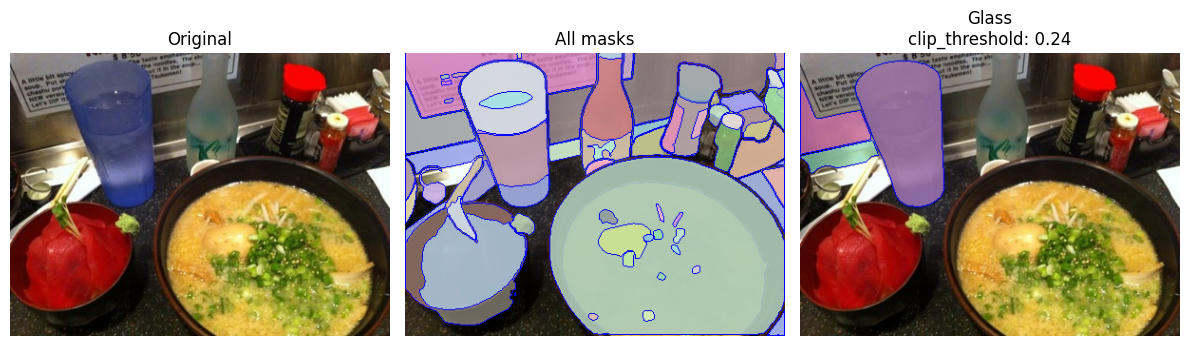

In [ ]:
predicted_iou_threshold = 0.5
stability_score_threshold = 0.8
clip_threshold = 0.24
prompt = "Glass"

segment(image,
        predicted_iou_threshold,
        stability_score_threshold,
        clip_threshold,
        prompt)

# Search for other images that has "Glass"

In [ ]:
num_samples = 1000
seed = 42
candidate_subset = dataset["train"].shuffle(seed=seed).select(range(num_samples))

In [ ]:
def search_inside_image(prompt,
                        predicted_iou_threshold: float,
                        stability_score_threshold: float,
                        clip_threshold: float,
                        top_k = 5):
  search_result = []
  for subset in tqdm(candidate_subset):
    subset_image = np.array(subset["image"])
    subset_label = subset["label"]
    masks = mask_generator.generate(subset_image)

    masks = filter_masks(
        subset_image,
        masks,
        predicted_iou_threshold,
        stability_score_threshold,
        prompt,
        clip_threshold,
    )
    if len(masks) > 0:
      search_result.append(subset)

      # Visualization Check
      # subset_label = draw_masks(subset_image, masks)
      # subset_image = cv2.cvtColor(subset_image, cv2.COLOR_BGR2RGB)
      # plt.imshow(subset_image)
      # plt.axis("off")
      # plt.show()

    if len(search_result) == top_k:
      break

  return search_result

In [ ]:
search_result = search_inside_image(prompt,
                                    predicted_iou_threshold,
                                    stability_score_threshold,
                                    clip_threshold)

  0%|          | 0/1000 [00:00<?, ?it/s]

max:  0.24671885 ave:  0.22191884
max:  0.25045055 ave:  0.22405012
max:  0.24035324 ave:  0.2243206
max:  0.23873623 ave:  0.22313586
max:  0.2412749 ave:  0.22275756
max:  0.2560423 ave:  0.22461972


## Visualize Search Result

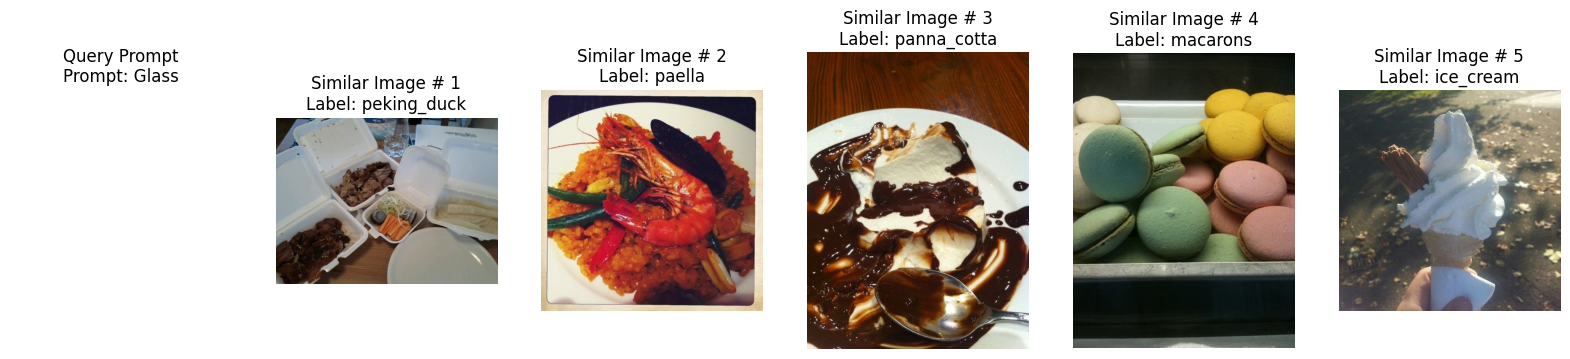

In [ ]:
def plot_images(images, labels):
    if not isinstance(labels, list):
        labels = labels.tolist()

    plt.figure(figsize=(20, 10))
    columns = 6
    for (i, image) in enumerate(images):
        label_id = labels[i]
        ax = plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        if i == 0:
            ax.set_title("Query Prompt\n" + f"Prompt: {label_id}")
        else:
            ax.set_title(
                "Similar Image # " + str(i) + "\nLabel: {}".format(id2label[int(label_id)])
            )
        plt.imshow(np.array(image).astype("int"))
        plt.axis("off")

images = []
labels = []

for id, search_image in enumerate(search_result):
    images.append(search_image["image"])
    labels.append(search_image["label"])

test_sample = np.zeros([100,100,3], dtype=np.uint8); test_sample.fill(255)
images.insert(0, test_sample)
labels.insert(0, prompt)
plot_images(images, labels)